#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
display(df.info(), df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

num_orders    0
dtype: int64

In [5]:
df.index.is_monotonic

True

<AxesSubplot:xlabel='datetime'>

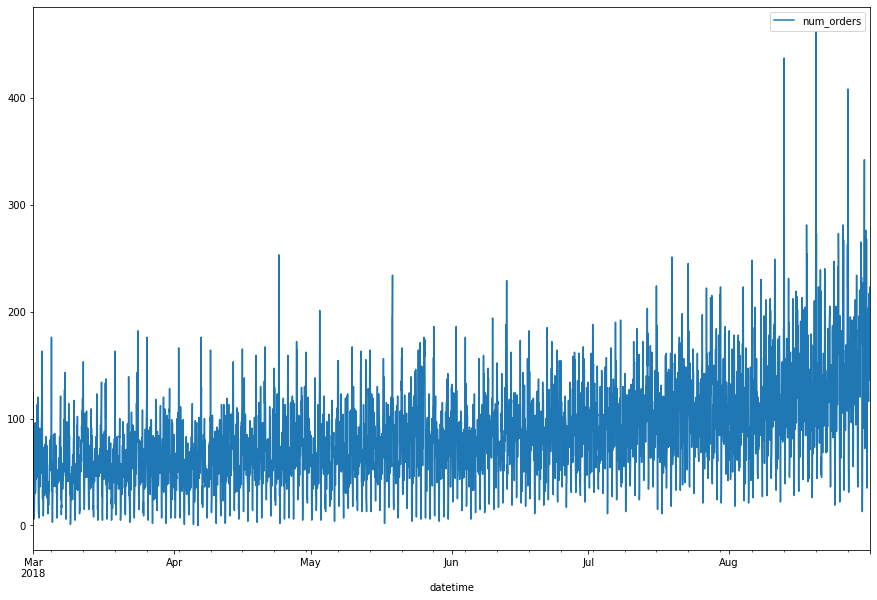

In [6]:
df = df.resample('1H').sum()
df.plot(figsize=(15,10))

Произведен ресемплинг по 1 часу. Данные расположены во временной последовательности, пропуски отсутствуют. Данные отражают количество заказов за десять минут (после ресемплирования – за час) с 1 марта по 31 августа 2018 года. 

## Анализ

In [7]:
df_trends = df.copy()
df_trends['rolling_mean'] = df.rolling(168).mean()

<AxesSubplot:xlabel='datetime'>

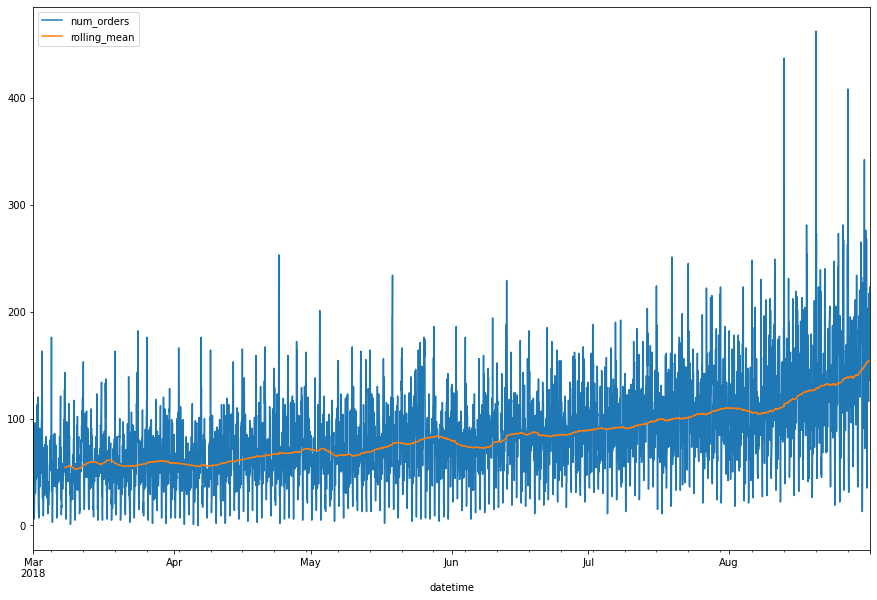

In [8]:
df_trends.plot(figsize=(15,10))

По скользящему среднему с интервалом в месяц можно проследить тренд: количество заказов увеличивается каждый месяц 2018 года

In [9]:
decomposed = seasonal_decompose(df)

<AxesSubplot:xlabel='datetime'>

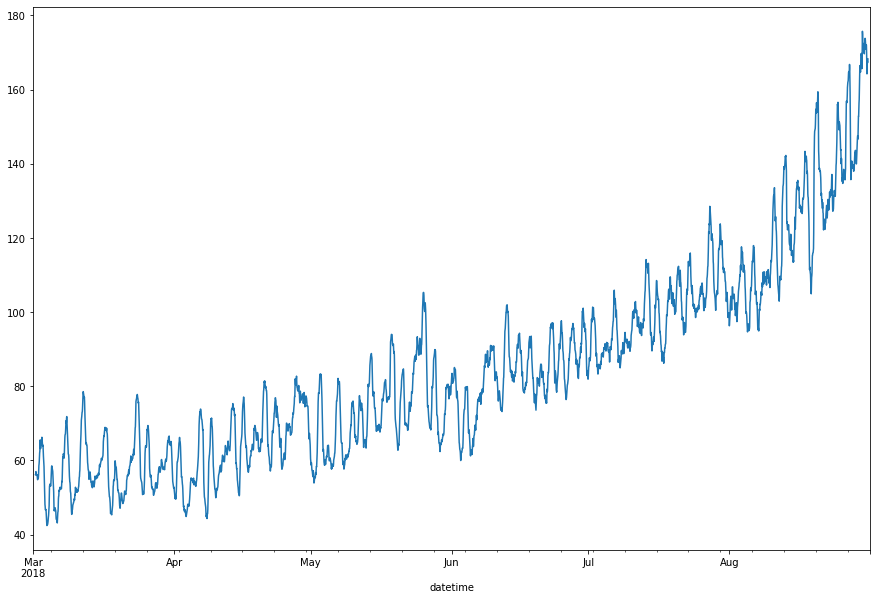

In [10]:
decomposed.trend.plot(figsize=(15,10))

<AxesSubplot:xlabel='datetime'>

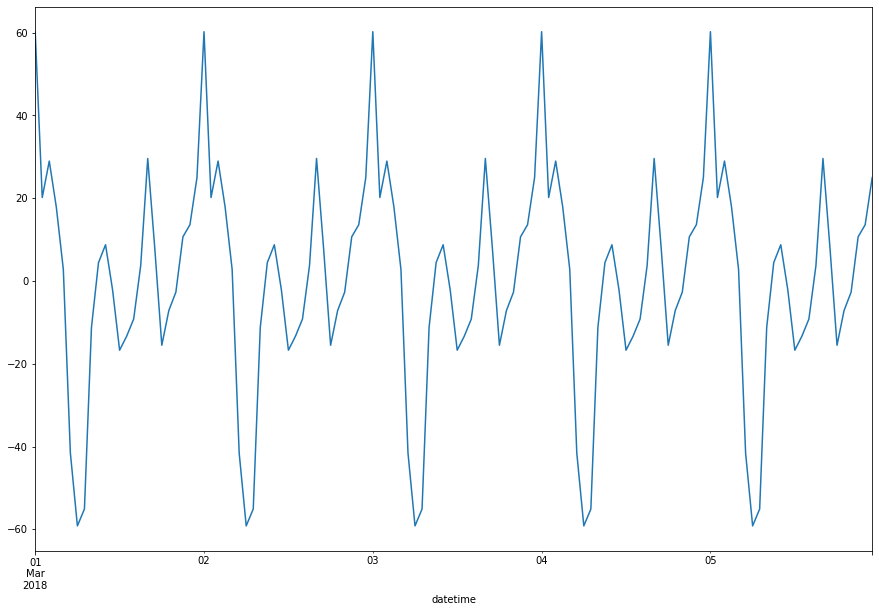

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(figsize=(15,10))

<AxesSubplot:xlabel='datetime'>

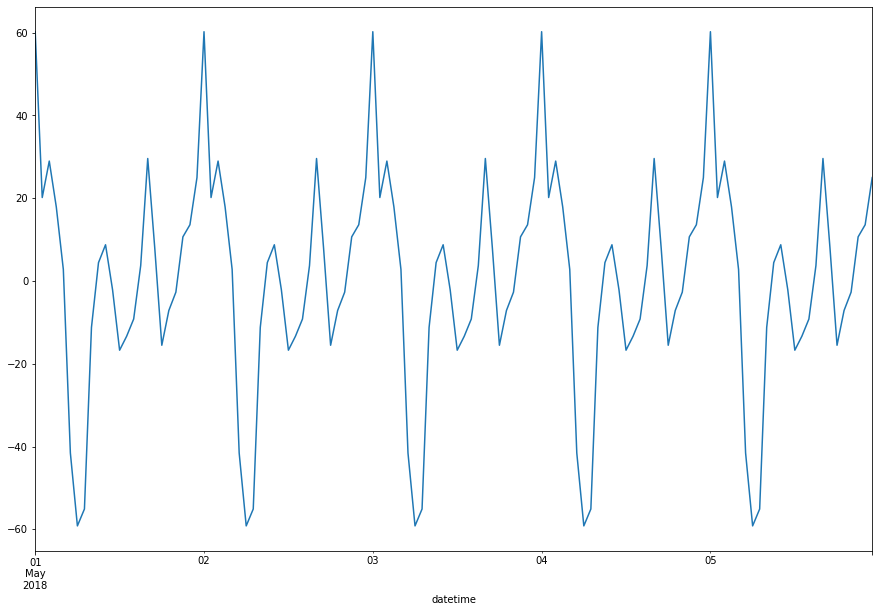

In [12]:
decomposed.seasonal['2018-05-01':'2018-05-05'].plot(figsize=(15,10))

Наблюдается сезонность – картина заказов примерно одинакова в одни и те же часы каждый день. Рассмотрим частотность за сутки в случайном дне.

/tmp/ipykernel_31/1304835873.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018-05-01'].plot(figsize=(15,10))
/tmp/ipykernel_31/1304835873.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018-05-31'].plot(figsize=(15,10))
/tmp/ipykernel_31/1304835873.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df['2018-08-15'].plot(figsize=(15,10))


<AxesSubplot:xlabel='datetime'>

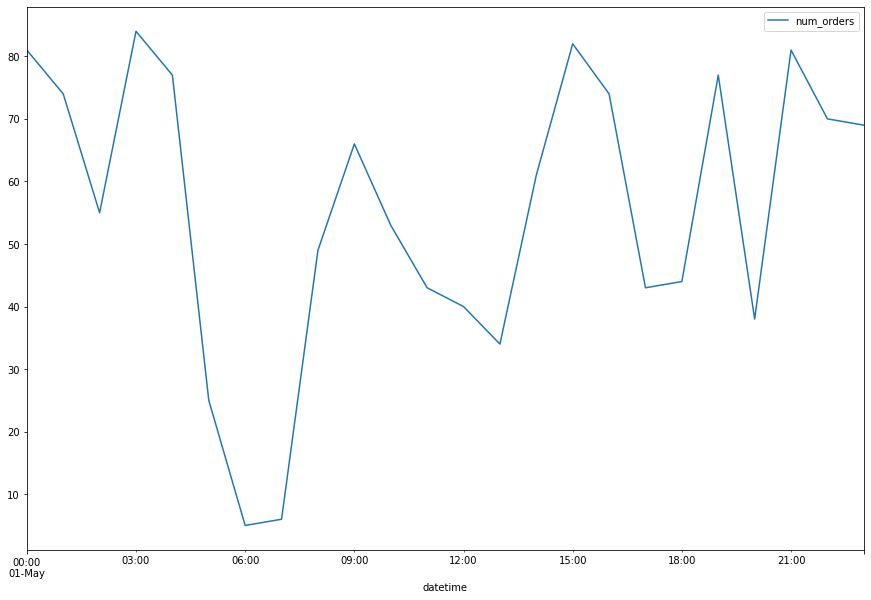

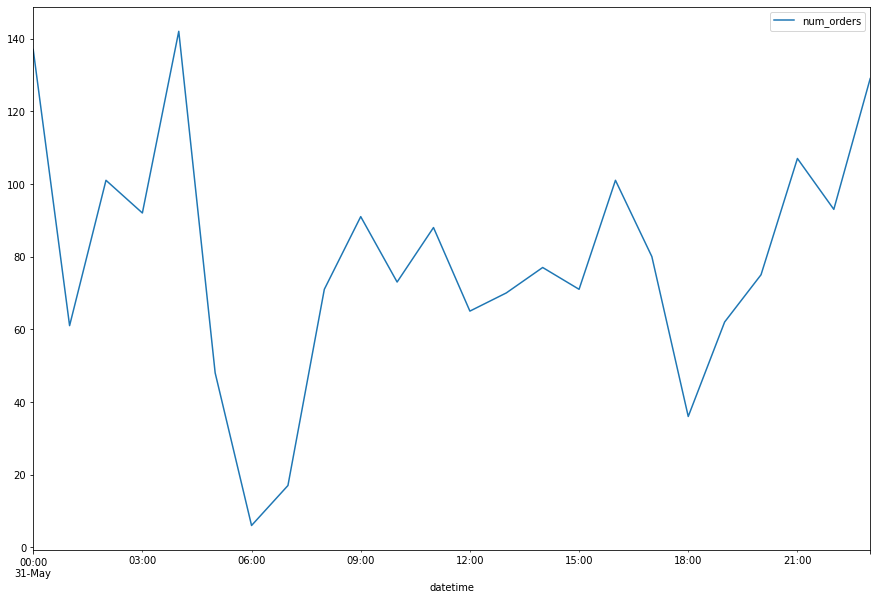

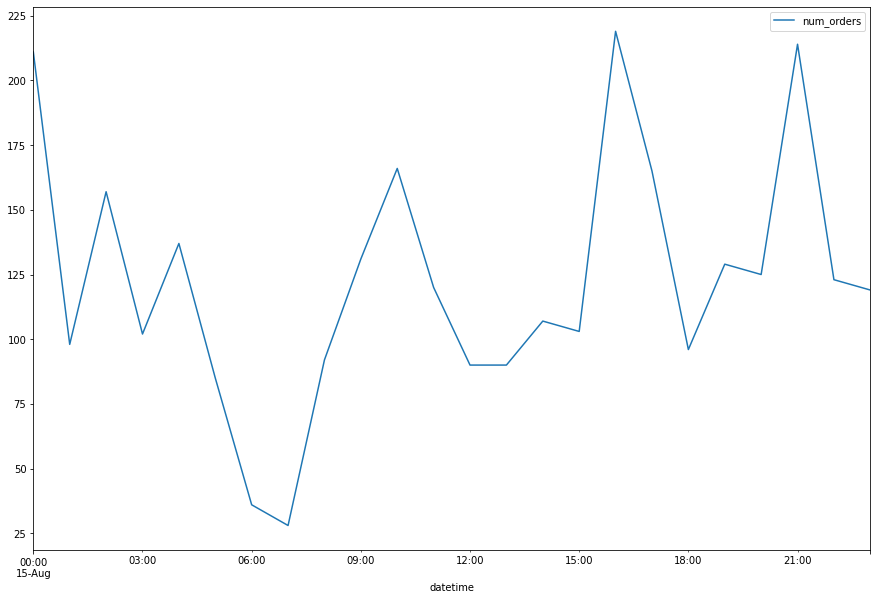

In [13]:
df['2018-05-01'].plot(figsize=(15,10))
df['2018-05-31'].plot(figsize=(15,10))
df['2018-08-15'].plot(figsize=(15,10))

<AxesSubplot:xlabel='datetime'>

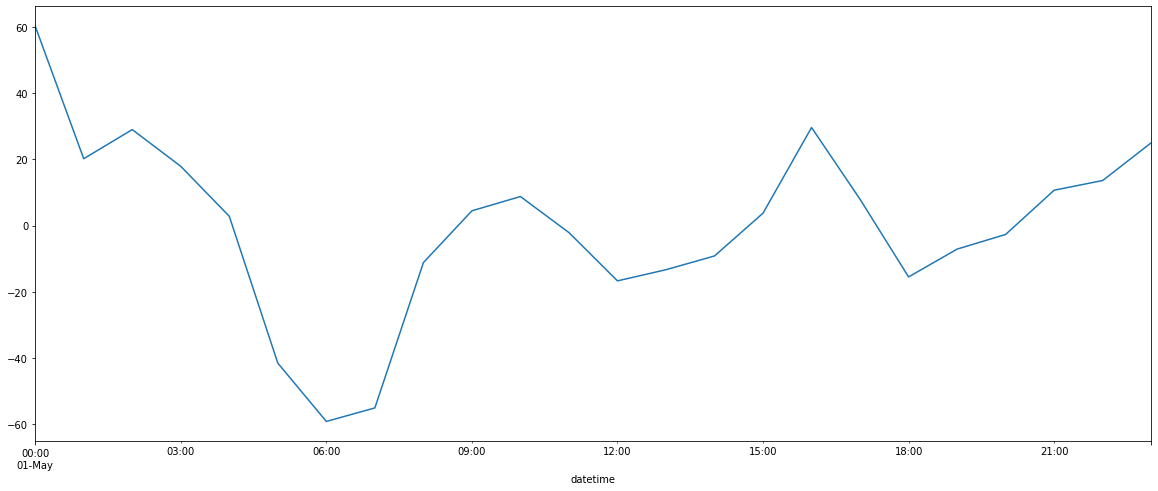

In [14]:
decomposed.seasonal['2018-05-01'].plot(figsize=(20,8))

В целом пики активности наблюдаются в райное 10 утра +- час, в 16-17 часов и плавно нарастает с 18 до полуночи, где наблюдается наибольшая активность.

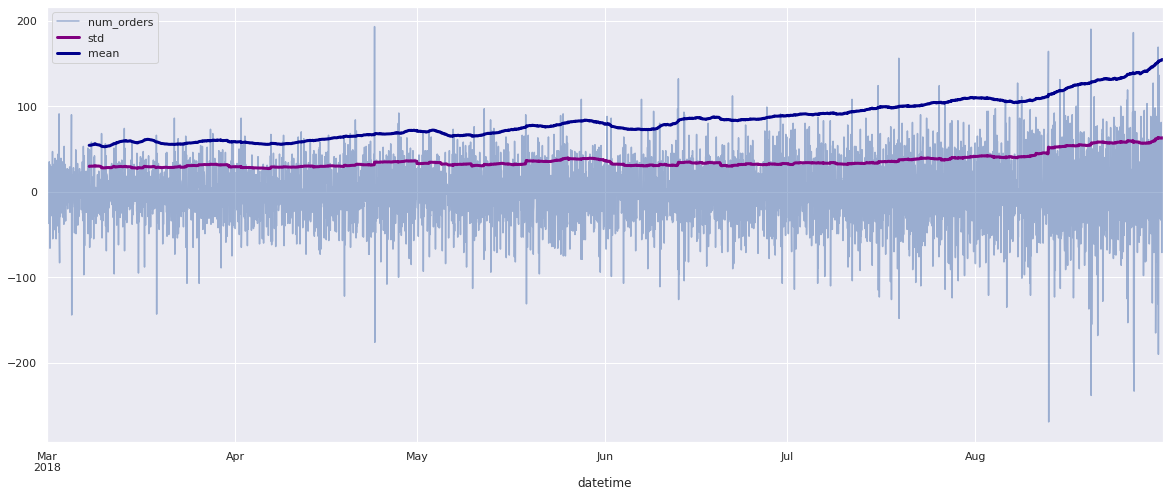

In [15]:
sns.set_theme()
df_diff = df - df.shift()
df_diff['mean'] = df['num_orders'].rolling(168).mean()
df_diff['std'] = df['num_orders'].rolling(168).std()
df_diff['num_orders'].plot(figsize=(30,8), alpha=0.5)
df_diff['std'].plot(figsize=(20,8), linewidth='3', color='purple')
df_diff['mean'].plot(figsize=(20,8), linewidth='3', color='darkblue')
plt.legend()
plt.show()

Описанный временной ряд приближается к стохастическому. Стандартное отклонение незначительно увеличивается. Такой ряд можно использовать для прогнозирования.

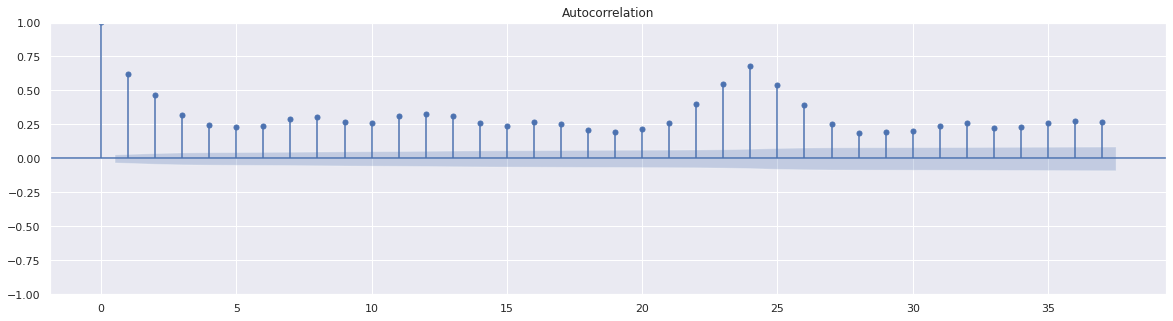

In [16]:
fig, ax = plt.subplots(figsize = (20,5))

plot_acf(df, ax = ax)

plt.show()

Видна высокая аутокорреляция каждые 24 часа (примерно 75%), что также подтверждает суточную сезонность данных. Определим этой цифрой максимальный лаг.

## Обучение

In [17]:
RS = np.random.RandomState(12345)
CV = TimeSeriesSplit()

In [18]:
df_new = df.copy()

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_new, 24, 168)

df_new.tail(30)

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-30 18:00:00,177,2018,8,30,3,342.0,254.0,156.0,91.0,154.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,149.321429
2018-08-30 19:00:00,72,2018,8,30,3,177.0,342.0,254.0,156.0,91.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,149.422619
2018-08-30 20:00:00,142,2018,8,30,3,72.0,177.0,342.0,254.0,156.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,149.363095
2018-08-30 21:00:00,198,2018,8,30,3,142.0,72.0,177.0,342.0,254.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,149.642857
2018-08-30 22:00:00,158,2018,8,30,3,198.0,142.0,72.0,177.0,342.0,...,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,149.738095
2018-08-30 23:00:00,246,2018,8,30,3,158.0,198.0,142.0,72.0,177.0,...,39.0,13.0,56.0,186.0,193.0,232.0,217.0,216.0,265.0,149.904762
2018-08-31 00:00:00,276,2018,8,31,4,246.0,158.0,198.0,142.0,72.0,...,166.0,39.0,13.0,56.0,186.0,193.0,232.0,217.0,216.0,150.357143
2018-08-31 01:00:00,194,2018,8,31,4,276.0,246.0,158.0,198.0,142.0,...,226.0,166.0,39.0,13.0,56.0,186.0,193.0,232.0,217.0,150.529762
2018-08-31 02:00:00,230,2018,8,31,4,194.0,276.0,246.0,158.0,198.0,...,227.0,226.0,166.0,39.0,13.0,56.0,186.0,193.0,232.0,150.648810


In [19]:
train, test = train_test_split(df_new, shuffle=False, test_size=0.1)
display(train.index.min(), train.index.max())
display(test.index.min(), test.index.max())

Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-13 13:00:00', freq='H')

Timestamp('2018-08-13 14:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

In [20]:
train = train.dropna()
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

Трейн и тест разделены по времени (тест = будущее), пропуски убраны, переменные для обучения созданы. 
Так как планка качества обучения уже задана, можно не создавать простое предсказание на основе среднего.

Для обучения возьму три разных модели: Ridge-регрессию, Случайный лес и CatBoostRegressor

In [21]:
model_ridge = Ridge(random_state=RS)
param_grid_ridge = {
    'alpha': np.arange(0.01, 1.0, 0.01),
}

grid_ridge = RandomizedSearchCV(
    model_ridge,
    param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=CV
)

grid_ridge.fit(features_train, target_train)

display(f'best_score: {grid_ridge.best_score_ * -1}')
display(f'best_params: {grid_ridge.best_params_}')

'best_score: 27.253736677251556'

"best_params: {'alpha': 0.9400000000000001}"

In [22]:
results_ridge = pd.DataFrame(grid_ridge.cv_results_)
display(results_ridge.sort_values(by='rank_test_score').head(5))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.056971,0.043135,0.002396,0.000247,0.94,{'alpha': 0.9400000000000001},-25.283093,-24.836011,-24.955532,-27.578523,-33.615524,-27.253737,3.334319,1
2,0.021763,0.034726,0.038161,0.043838,0.91,{'alpha': 0.91},-25.283075,-24.836013,-24.955521,-27.578532,-33.615562,-27.253741,3.334337,2
0,0.041537,0.042295,0.024640,0.034165,0.88,{'alpha': 0.88},-25.283057,-24.836015,-24.955509,-27.578541,-33.615601,-27.253745,3.334355,3
8,0.038789,0.042373,0.020192,0.035601,0.71,{'alpha': 0.7100000000000001},-25.282956,-24.836025,-24.955444,-27.578592,-33.615817,-27.253767,3.334458,4
4,0.038777,0.042202,0.020105,0.035409,0.58,{'alpha': 0.5800000000000001},-25.282877,-24.836033,-24.955394,-27.578632,-33.615983,-27.253784,3.334537,5


In [23]:
model_rf = RandomForestRegressor(random_state=RS)
param_grid_rf = {
    'n_estimators': range(50, 200, 10),
    'max_depth': range(1,11,2)
}

grid_rf = RandomizedSearchCV(
    model_rf,
    param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=CV
)

grid_rf.fit(features_train, target_train)

display(f'best_score: {grid_rf.best_score_ * -1}')
display(f'best_params: {grid_rf.best_params_}')

'best_score: 26.236695785836922'

"best_params: {'n_estimators': 100, 'max_depth': 9}"

In [24]:
model_cat = CatBoostRegressor(verbose=False)
param_grid_cat = {
    
    'iterations': range(50, 200, 50),
    'learning_rate': np.arange(0.01, 0.1, 0.5),
    'depth': range(2, 9, 1),
    'l2_leaf_reg': (0.05, 3, 2)

}
grid_cat = RandomizedSearchCV(
    model_cat,
    param_grid_cat,
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1,
    cv=CV
)

grid_cat.fit(features_train, target_train)

display(f'best_score: {grid_cat.best_score_ * -1}')
display(f'best_params: {grid_cat.best_params_}')

'best_score: 29.92559451140936'

"best_params: {'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 150, 'depth': 7}"

In [25]:
contest_table = pd.DataFrame({'Модель': {0:'Ridge', 1:'RandomForest', 2:'CatBoost'}, 
                              'Результат обучения': {0:grid_ridge.best_score_ * -1, 1:grid_rf.best_score_ * -1, 2:grid_cat.best_score_ * -1},
                             'Лучшие параметры': {0:grid_ridge.best_params_, 1: grid_rf.best_params_, 2: grid_cat.best_params_}}
                            )

subset=['Результат обучения']
display(contest_table
        .style
        .highlight_min(color='yellowgreen', subset=subset)
        .highlight_max(color='coral', subset=subset))

,Модель,Результат обучения,Лучшие параметры
0,Ridge,27.253737,{'alpha': 0.9400000000000001}
1,RandomForest,26.236696,"{'n_estimators': 100, 'max_depth': 9}"
2,CatBoost,29.925595,"{'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 150, 'depth': 7}"


По результатам обучения и кросс-валидации лучшей моделью показала себя RandomForest, проведем ее тестирование.

## Тестирование

In [26]:
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [27]:
test_rf = grid_rf.predict(features_test)

In [28]:
print(f'Результат тестирования лучшей модели: {mean_squared_error(target_test, test_rf, squared=False)}')

Результат тестирования лучшей модели: 43.94518296536595


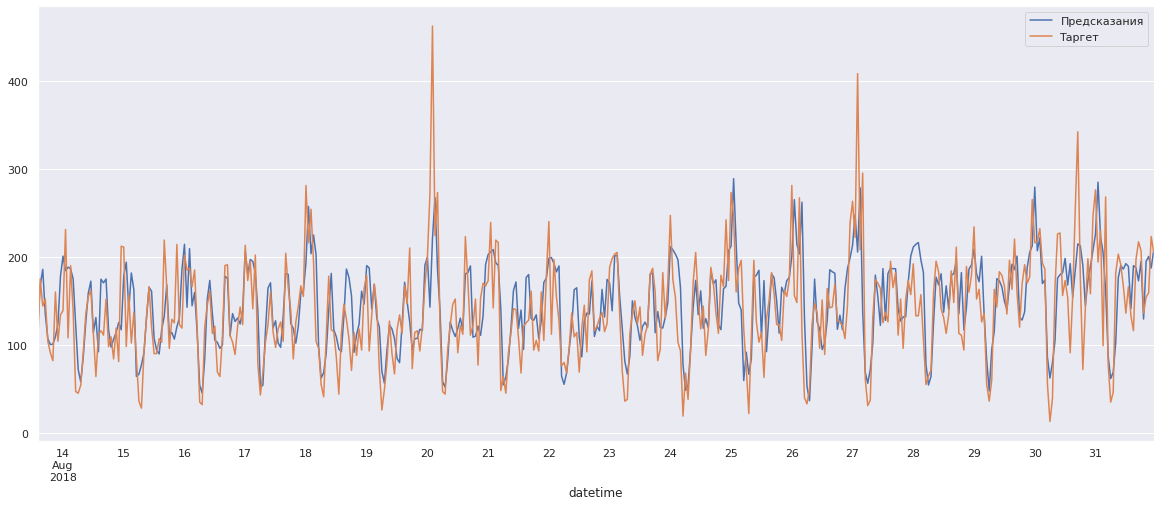

In [52]:
test_df = pd.DataFrame(test_rf, index=target_test.index)
test_df.plot(figsize=(20,8))
target_test.plot(figsize=(20,8))
plt.legend(['Предсказания', 'Таргет'])

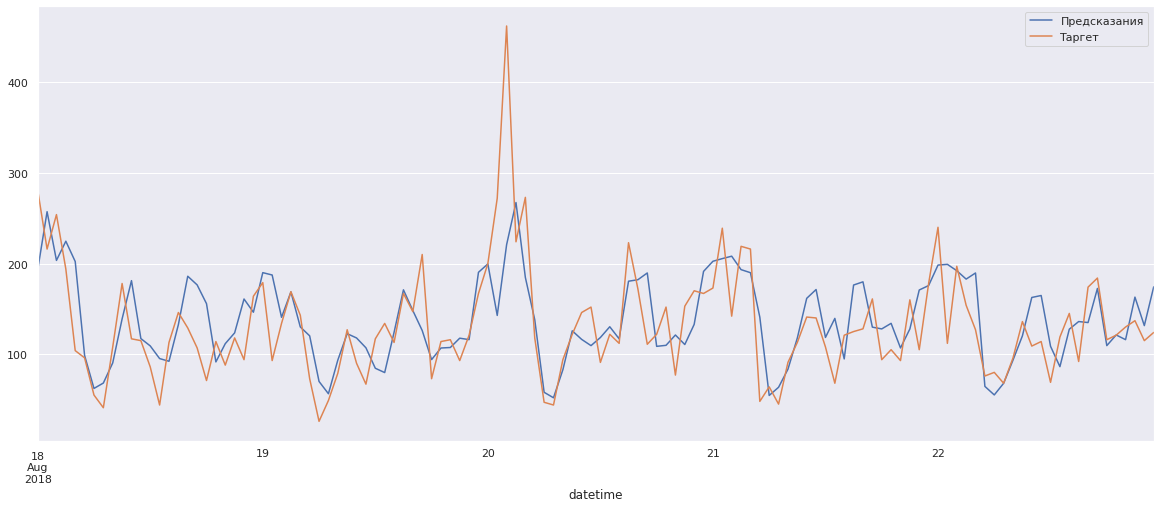

In [53]:
test_df['2018-08-18':'2018-08-22'].plot(figsize=(20,8))
target_test['2018-08-18':'2018-08-22'].plot(figsize=(20,8))
plt.legend(['Предсказания', 'Таргет'])

<h3> <b> Вывод: по результатам тестирования модель Случайного леса способна прогнозировать количество заказов на следующий час.
    
    Данные были приведены к типу DateTimeIndex, отсортированы во временном порядке и очищены от пропусков. Анализ данных показал, что присутствует тренд к увеличению количества заказов в будущем и схожесть картины закаов по часам, что подтверждено аутокорреляцией с лагом в 24 часа.
    
    Было обучено и провалидировано несколько моделей, лучшей из которых оказалась модель Случайного леса. При тестировании модель показала достаточно высокий результат, чтобы сказать, что она оптимально для поставленной задачи предсказывает количество заказов на следующий час.